# Downloads/Imports

In [ ]:
!pip install opencv-python pillow albumentations scikit-learn pyyaml tqdm

In [ ]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset
!cd PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 1 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 34.56 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


In [ ]:
!unzip backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/soil9.jpg   
  inflating: __MACOSX/backgrounds/._soil9.jpg  
  inflating: backgrounds/soil8.jpg   
  inflating: __MACOSX/backgrounds/._soil8.jpg  
  inflating: backgrounds/.DS_Store   
  inflating: __MACOSX/backgrounds/._.DS_Store  
  inflating: backgrounds/soil17.jpeg  
  inflating: __MACOSX/backgrounds/._soil17.jpeg  
  inflating: backgrounds/soil16.jpg  
  inflating: __MACOSX/backgrounds/._soil16.jpg  
  inflating: backgrounds/soil6.jpeg  
  inflating: __MACOSX/backgrounds/._soil6.jpeg  
  inflating: backgrounds/soil14.jpg  
  inflating: __MACOSX/backgrounds/._soil14.jpg  
  inflating: backgrounds/soil10.jpg  
  inflating: __MACOSX/backgrounds/._soil10.jpg  
  inflating: backgrounds/soil13.jpg  
  inflating: __MACOSX/backgrounds/._soil13.jpg  
  inflating: backgrounds/soil12.jpg  
  inflating: __MACOSX/backgrounds/._soil12.jpg  
  inflating: backgrounds/soil11.jpeg  
  inflating: __MACOSX/backgrounds/._soil

In [ ]:
import cv2
import numpy as np
import os
import random
from pathlib import Path
from PIL import Image, ImageEnhance
import albumentations as A
from sklearn.model_selection import train_test_split
import shutil
import yaml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import requests
from io import BytesIO
from tqdm import tqdm
import itertools
import glob
import seaborn as sns
from collections import Counter

# Dataset generator

=== First run: Extracting leaves and generating dataset ===
Scanning for source images...
Found 54305 total source images
Found 54305 total source images
Organizing images by class...
Limiting to 10000 total images systematically...
Attempting to sample up to 263 images from each of 38 classes.
Created a balanced sample of 9883 images.
Extracting leaves from 9883 source images...


Extracting Leaves: 100%|██████████| 9883/9883 [00:51<00:00, 190.73it/s]


Successfully cached 9875 leaves
Using 9875 cached leaves for synthetic image generation
Starting generation, balancing across 38 available classes.
Class order head (IDs): [18, 6, 16, 15, 34]...
Generating synthetic images...


Generating Images: 100%|██████████| 10000/10000 [14:53<00:00, 11.19it/s]


Dataset generation complete! Successfully generated 10000/10000 images
Created YOLO config with 8000 training and 2000 validation images


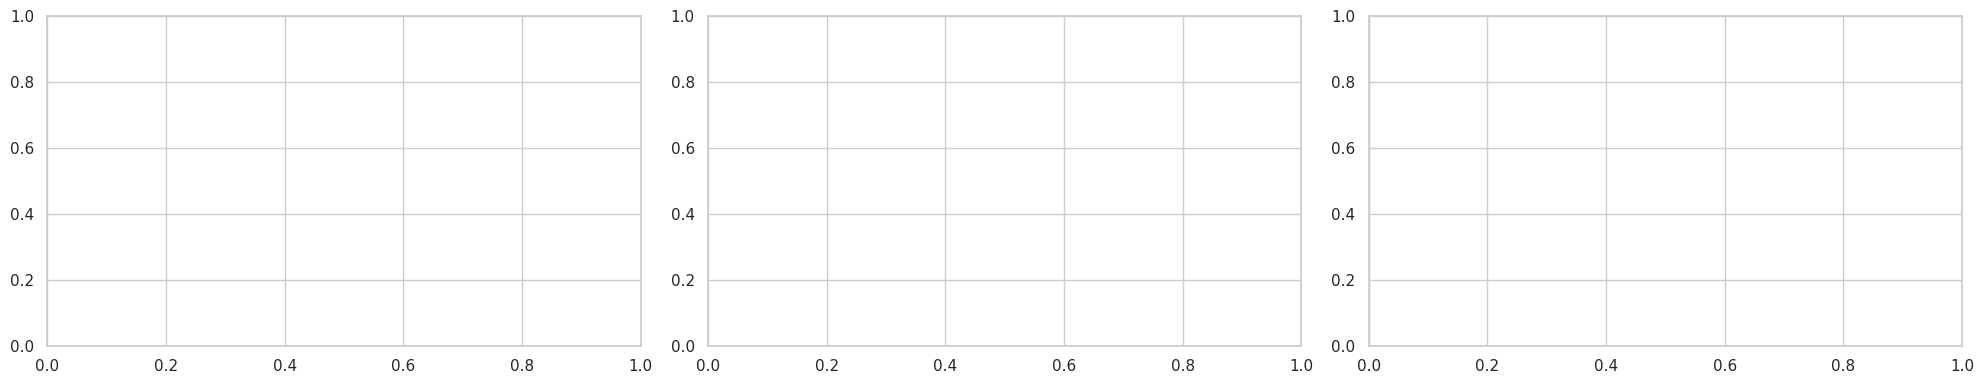

Enhanced synthetic dataset creation complete!


In [ ]:
class LeafDatasetGenerator:
    def __init__(self, source_dataset_path, output_path, background_path=None, cache_path=None):
        self.source_dataset_path = Path(source_dataset_path)
        self.output_path = Path(output_path)
        self.background_path = Path(background_path) if background_path else None
        self.cache_path = Path(cache_path) if cache_path else Path(output_path) / 'leaf_cache'

        # Create output directories
        self.output_path.mkdir(parents=True, exist_ok=True)
        (self.output_path / 'images').mkdir(exist_ok=True)
        (self.output_path / 'labels').mkdir(exist_ok=True)
        self.cache_path.mkdir(parents=True, exist_ok=True)

        # YOLO class names
        self.class_names = [
        "Apple___Apple_scab",
        "Apple___Black_rot",
        "Apple___Cedar_apple_rust",
        "Apple___healthy",
        "Blueberry___healthy",
        "Cherry_(including_sour)___Powdery_mildew",
        "Cherry_(including_sour)___healthy",
        "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
        "Corn_(maize)___Common_rust_",
        "Corn_(maize)___Northern_Leaf_Blight",
        "Corn_(maize)___healthy",
        "Grape___Black_rot",
        "Grape___Esca_(Black_Measles)",
        "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
        "Grape___healthy",
        "Orange___Haunglongbing_(Citrus_greening)",
        "Peach___Bacterial_spot",
        "Peach___healthy",
        "Pepper,_bell___Bacterial_spot",
        "Pepper,_bell___healthy",
        "Potato___Early_blight",
        "Potato___Late_blight",
        "Potato___healthy",
        "Raspberry___healthy",
        "Soybean___healthy",
        "Squash___Powdery_mildew",
        "Strawberry___Leaf_scorch",
        "Strawberry___healthy",
        "Tomato___Bacterial_spot",
        "Tomato___Early_blight",
        "Tomato___Late_blight",
        "Tomato___Leaf_Mold",
        "Tomato___Septoria_leaf_spot",
        "Tomato___Spider_mites Two-spotted_spider_mite",
        "Tomato___Target_Spot",
        "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
        "Tomato___Tomato_mosaic_virus",
        "Tomato___healthy"
        ]
        self.class_to_id = {name: idx for idx, name in enumerate(self.class_names)}

        # Background types for more variety
        self.background_types = ['gradient', 'texture', 'solid', 'natural']

    def extract_leaves(self, image_path):
        """Extract leaf from image using edge detection and masking"""
        try:
            # Read image
            image = cv2.imread(str(image_path))
            if image is None:
                return None, None, None

            # Get class name from directory structure
            class_name = image_path.parent.name
            # Map to our simplified classes (you'll need to customize this mapping)
            if class_name not in self.class_to_id:
                print(f"Warning: Unknown class {class_name}")
                return None, None, None

            class_id = self.class_to_id[class_name]

            # Convert to different color spaces
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

            # Create multiple masks for better leaf extraction
            # Green color mask in HSV
            lower_green = np.array([25, 40, 40])
            upper_green = np.array([90, 255, 255])
            mask_green = cv2.inRange(hsv, lower_green, upper_green)

            # Brightness mask in LAB
            L = lab[:,:,0]
            mask_bright = cv2.threshold(L, 30, 255, cv2.THRESH_BINARY)[1]

            # Combine masks
            combined_mask = cv2.bitwise_and(mask_green, mask_bright)

            # Morphological operations to clean up the mask
            kernel = np.ones((5,5), np.uint8)
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

            # Find contours
            contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                return None, None, None

            # Get the largest contour (assuming it's the leaf)
            largest_contour = max(contours, key=cv2.contourArea)

            # Create a bounding rectangle around the leaf
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Extract leaf with some padding
            padding = 10
            x1 = max(0, x - padding)
            y1 = max(0, y - padding)
            x2 = min(image.shape[1], x + w + padding)
            y2 = min(image.shape[0], y + h + padding)

            cropped_leaf = image[y1:y2, x1:x2]

            # Create mask for the extracted region
            mask = np.zeros(image.shape[:2], np.uint8)
            cv2.drawContours(mask, [largest_contour], -1, 255, -1)
            cropped_mask = mask[y1:y2, x1:x2]

            return cropped_leaf, cropped_mask, class_id

        except Exception as e:
            print(f"Error extracting leaf from {image_path}: {e}")
            return None, None, None

    def save_leaf_to_cache(self, leaf, mask, class_id, original_path, cache_id):
        """Save extracted leaf to cache directory"""
        try:
            # Create cache entry
            cache_entry = {
                'leaf': leaf,
                'mask': mask,
                'class_id': class_id,
                'class_name': self.class_names[class_id],
                'original_path': str(original_path),
                'cache_id': cache_id
            }

            # Save as pickle file
            cache_file = self.cache_path / f"leaf_{cache_id:08d}.pkl"
            with open(cache_file, 'wb') as f:
                pickle.dump(cache_entry, f)

            # Also save as image for visualization
            img_file = self.cache_path / f"leaf_{cache_id:08d}.jpg"
            cv2.imwrite(str(img_file), leaf)

            return True
        except Exception as e:
            print(f"Error saving leaf to cache: {e}")
            return False

    def load_leaf_from_cache(self, cache_id):
        """Load leaf from cache by ID"""
        try:
            cache_file = self.cache_path / f"leaf_{cache_id:08d}.pkl"
            with open(cache_file, 'rb') as f:
                cache_entry = pickle.load(f)
            return cache_entry
        except Exception as e:
            print(f"Error loading leaf from cache {cache_id}: {e}")
            return None

    def load_all_cached_leaves(self):
        """Load all cached leaves into memory"""
        cache_files = list(self.cache_path.glob("leaf_*.pkl"))
        cached_leaves = []

        for cache_file in cache_files:
            try:
                with open(cache_file, 'rb') as f:
                    cache_entry = pickle.load(f)
                    cached_leaves.append(cache_entry)
            except Exception as e:
                print(f"Error loading {cache_file}: {e}")

        return cached_leaves

    def extract_and_cache_leaves(self, max_source_images=None, force_reextract=False):
        """
        Extract leaves from source images and cache them systematically to
        ensure a more balanced class representation.
        """
        print("Collecting source images...")
        all_source_images = self.collect_source_images()

        if not all_source_images:
            raise ValueError("No source images found!")

        print(f"Found {len(all_source_images)} total source images")

        # Organize images by class ---
        print("Organizing images by class...")
        images_by_class = {name: [] for name in self.class_names}
        unknown_classes = set()

        for img_path in all_source_images:
            # Get class name from parent directory
            class_name = img_path.parent.name
            if class_name in self.class_to_id:
                images_by_class[class_name].append(img_path)
            else:
                unknown_classes.add(class_name)

        if unknown_classes:
            print(f"Warning: Skipped unknown class directories: {unknown_classes}")

        # Apply max_source_images systematically
        source_images_to_process = []
        if max_source_images and max_source_images < len(all_source_images):
            print(f"Limiting to {max_source_images} total images systematically...")

            # Find which classes actually have images
            available_classes = [name for name, imgs in images_by_class.items() if imgs]
            if not available_classes:
                 raise ValueError("No images found for any known class!")

            num_classes = len(available_classes)
            # Calculate how many images to take from each class
            images_per_class = max(1, int(max_source_images / num_classes))

            print(f"Attempting to sample up to {images_per_class} images from each of {num_classes} classes.")

            total_sampled = 0
            for class_name in available_classes:
                class_images = images_by_class[class_name]
                random.shuffle(class_images) # Shuffle to get variety from this class

                # How many to take from this class
                # We take the *minimum* of:
                #   1. The per-class quota
                #   2. How many images the class actually has
                #   3. The remaining overall quota
                images_to_take_for_class = min(len(class_images), images_per_class)
                remaining_total_quota = max_source_images - total_sampled

                if remaining_total_quota <= 0:
                    break # Stop if we've hit the global limit

                images_to_take = min(images_to_take_for_class, remaining_total_quota)

                source_images_to_process.extend(class_images[:images_to_take])
                total_sampled += images_to_take

            print(f"Created a balanced sample of {len(source_images_to_process)} images.")

        else:
            # No limit, or limit is larger than total images. Use all.
            print("Using all available source images.")
            source_images_to_process = all_source_images


        # Check if cache already exists and we don't want to re-extract
        # This logic remains the same. If the user wants a new balanced cache,
        # they MUST set force_reextract=True.
        cache_files = list(self.cache_path.glob("leaf_*.pkl"))
        if cache_files and not force_reextract:
            print(f"Found {len(cache_files)} cached leaves. Loading from cache...")
            return self.load_all_cached_leaves()

        # Extract and cache leaves
        print(f"Extracting leaves from {len(source_images_to_process)} source images...")
        cached_leaves = []
        cache_id = 0
        successful_extractions = 0

        # This loop now iterates over the balanced `source_images_to_process` list
        for img_path in tqdm(source_images_to_process, desc="Extracting Leaves"):

            leaf, mask, class_id = self.extract_leaves(img_path)
            if leaf is not None and mask is not None:
                if self.save_leaf_to_cache(leaf, mask, class_id, img_path, cache_id):
                    cached_leaves.append({
                        'leaf': leaf,
                        'mask': mask,
                        'class_id': class_id,
                        'class_name': self.class_names[class_id],
                        'cache_id': cache_id
                    })
                    successful_extractions += 1
                cache_id += 1 # Increment cache_id regardless of success to avoid overwrites

        print(f"Successfully cached {successful_extractions} leaves")
        return cached_leaves

    def augment_bg(self, image):
        """Apply random augmentations to the leaf including rotation"""
        try:
            # Enhanced transformations with more rotation options
            transform = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
                A.Blur(blur_limit=3, p=0.2),
                A.RandomGamma(gamma_limit=(80, 120), p=0.2),
            ])

            augmented = transform(image=image)
            return augmented['image']

        except Exception as e:
            print(f"Error augmenting image: {e}")
            return image

    def get_random_background(self, target_size=(640, 640)):
        """Get random background with more variety"""
        # Use provided background images if available
        if self.background_path and self.background_path.exists():
            bg_files = list(self.background_path.glob('*.jpg')) + list(self.background_path.glob('*.png'))
            if bg_files:
                bg_path = random.choice(bg_files)
                bg = cv2.imread(str(bg_path))
                if bg is not None:
                    bg = cv2.resize(bg, target_size)
                    bg = self.augment_bg(bg)
                    return bg

    def augment_leaf(self, leaf, mask):
        """Apply random augmentations to the leaf including rotation"""
        try:
            # Enhanced transformations with more rotation options
            transform = A.Compose([
                A.Rotate(limit=360, p=0.8),  # Full 360-degree rotation
                A.RandomRotate90(p=0.3),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
                A.Blur(blur_limit=3, p=0.2),
                A.RandomGamma(gamma_limit=(80, 120), p=0.2),
                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
            ])

            augmented = transform(image=leaf, mask=mask)
            return augmented['image'], augmented['mask']

        except Exception as e:
            print(f"Error augmenting leaf: {e}")
            return leaf, mask

    def calculate_rotated_bounding_box(self, width, height, angle):
        """Calculate bounding box after rotation - improved version"""
        # Convert angle to radians
        angle_rad = np.radians(angle)

        # Calculate the bounding box of the rotated rectangle
        cos_angle = abs(np.cos(angle_rad))
        sin_angle = abs(np.sin(angle_rad))

        new_width = width * cos_angle + height * sin_angle
        new_height = width * sin_angle + height * cos_angle

        return int(new_width), int(new_height)

    def place_leaf_on_background(self, background, leaf, mask, class_id, bboxes):
        """
        Place a leaf on the background with random position, size, and rotation.
        Starts at a random position. If overlapping > 30% IoU, it moves
        left and right, following the direction of decreasing overlap
        until the 30% threshold is met.
        """
        bg_height, bg_width = background.shape[:2]

        # --- Helper function (nested) for IoU calculation ---
        def get_max_iou(new_box_px, existing_bboxes_yolo, bg_width, bg_height):
            """Calculate the max IoU of a new box against all existing boxes."""
            new_x1, new_y1, new_x2, new_y2 = new_box_px
            new_area = (new_x2 - new_x1) * (new_y2 - new_y1)
            if new_area <= 0: return 1.0  # Invalid box

            max_iou = 0.0
            for existing_bbox in existing_bboxes_yolo:
                # Convert existing YOLO box [class, cx, cy, w, h] to pixel [x1, y1, x2, y2]
                _, ex_cx, ex_cy, ex_w, ex_h = existing_bbox
                ex_w_px = ex_w * bg_width
                ex_h_px = ex_h * bg_height
                old_x1 = (ex_cx * bg_width) - (ex_w_px / 2)
                old_y1 = (ex_cy * bg_height) - (ex_h_px / 2)
                old_x2 = old_x1 + ex_w_px
                old_y2 = old_y1 + ex_h_px
                old_area = ex_w_px * ex_h_px

                # Calculate intersection coordinates
                inter_x1 = max(new_x1, old_x1)
                inter_y1 = max(new_y1, old_y1)
                inter_x2 = min(new_x2, old_x2)
                inter_y2 = min(new_y2, old_y2)

                # Calculate intersection area
                inter_width = max(0, inter_x2 - inter_x1)
                inter_height = max(0, inter_y2 - inter_y1)
                inter_area = inter_width * inter_height

                # Calculate union area
                union_area = new_area + old_area - inter_area
                iou = inter_area / union_area if union_area > 0 else 0
                max_iou = max(max_iou, iou)

            return max_iou
        # --- End of helper function ---


        # Random scale (0.3 to 0.8 of background size for more realistic sizing)
        max_scale = min(bg_width / leaf.shape[1], bg_height / leaf.shape[0]) * 0.5
        min_scale = min(bg_width / leaf.shape[1], bg_height / leaf.shape[0]) * 0.4
        scale = random.uniform(min_scale, max_scale)

        # Resize leaf and mask
        new_width = int(leaf.shape[1] * scale)
        new_height = int(leaf.shape[0] * scale)

        if new_width == 0 or new_height == 0:
            return background, None

        leaf_resized = cv2.resize(leaf, (new_width, new_height))
        mask_resized = cv2.resize(mask, (new_width, new_height))

        # Random rotation (0-360 degrees)
        angle = random.uniform(0, 360)

        # Calculate rotated dimensions
        rot_width, rot_height = self.calculate_rotated_bounding_box(new_width, new_height, angle)

        # Adjust for very small rotations
        if rot_width < 5 or rot_height < 5:
            return background, None

        # Rotate leaf and mask
        center = (new_width // 2, new_height // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Adjust rotation matrix for the new dimensions
        rotation_matrix[0, 2] += (rot_width - new_width) / 2
        rotation_matrix[1, 2] += (rot_height - new_height) / 2

        # Apply rotation
        leaf_rotated = cv2.warpAffine(leaf_resized, rotation_matrix, (rot_width, rot_height),
                                     flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(0, 0, 0))
        mask_rotated = cv2.warpAffine(mask_resized, rotation_matrix, (rot_width, rot_height),
                                     flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=0)

        # Calculate max possible top-left coordinates
        max_x = bg_width - rot_width
        max_y = bg_height - rot_height

        if max_x <= 0 or max_y <= 0:
            return background, None

        # Greedy Iterative Search

        MAX_SEARCH_STEPS_PER_DIR = 30  # Max steps to check left or right
        # Step size is 5% of width, or at least 5 pixels
        step_size_x = max(7.5, int(rot_width * 0.075))

        # Start with a random position
        start_x = random.randint(0, max_x)
        start_y = random.randint(0, max_y)

        final_x, final_y = -1, -1
        found_position = False

        # 1. Check initial random position
        current_box_px = [start_x, start_y, start_x + rot_width, start_y + rot_height]
        current_iou = get_max_iou(current_box_px, bboxes, bg_width, bg_height)

        if current_iou <= 0.3:
            found_position = True
            final_x, final_y = start_x, start_y
        else:
            # 2. Search Right
            best_iou_right = current_iou
            best_x_right = start_x

            for i in range(1, MAX_SEARCH_STEPS_PER_DIR + 1):
                new_x = start_x + i * step_size_x
                if new_x > max_x:  # Hit edge
                    break

                new_box_px = [new_x, start_y, new_x + rot_width, start_y + rot_height]
                new_iou = get_max_iou(new_box_px, bboxes, bg_width, bg_height)

                if new_iou <= 0.3:
                    # Found a valid spot
                    final_x, final_y = new_x, start_y
                    found_position = True
                    break

                if new_iou < best_iou_right:
                    # Overlap is decreasing, keep going
                    best_iou_right = new_iou
                    best_x_right = new_x
                else:
                    # Overlap increased or stayed the same, stop this direction
                    break

            # 3. Search Left (only if not already found)
            if not found_position:
                best_iou_left = current_iou
                best_x_left = start_x

                for i in range(1, MAX_SEARCH_STEPS_PER_DIR + 1):
                    new_x = start_x - i * step_size_x
                    if new_x < 0:  # Hit edge
                        break

                    new_box_px = [new_x, start_y, new_x + rot_width, start_y + rot_height]
                    new_iou = get_max_iou(new_box_px, bboxes, bg_width, bg_height)

                    if new_iou <= 0.3:
                        # Found a valid spot
                        final_x, final_y = new_x, start_y
                        found_position = True
                        break

                    if new_iou < best_iou_left:
                        # Overlap is decreasing, keep going
                        best_iou_left = new_iou
                        best_x_left = new_x
                    else:
                        # Overlap increased or stayed the same, stop this direction
                        break

        if not found_position:
            # Failed to find a suitable spot after all checks
            return background, None

        # Use the validated position for blending
        x, y = final_x, final_y

        # Create blended result
        result = background.copy()

        # Use mask to blend leaf onto background
        mask_bool = mask_rotated > 128

        # Ensure we don't go out of bounds
        y_end = min(y + rot_height, bg_height)
        x_end = min(x + rot_width, bg_width)
        actual_height = y_end - y
        actual_width = x_end - x

        if actual_height <= 0 or actual_width <= 0:
            return background, None

        roi = result[y:y_end, x:x_end]
        leaf_region = leaf_rotated[:actual_height, :actual_width]
        mask_region = mask_bool[:actual_height, :actual_width]

        # Blend using the mask with some transparency for more natural look
        alpha = random.uniform(0.8, 1.0)  # Slight transparency variation
        roi[mask_region] = cv2.addWeighted(leaf_region[mask_region], alpha,
                                          roi[mask_region], 1-alpha, 0)
        result[y:y_end, x:x_end] = roi

        # Calculate YOLO format bounding box (normalized)
        yolo_x = (x + actual_width / 2) / bg_width
        yolo_y = (y + actual_height / 2) / bg_height
        yolo_w = actual_width / bg_width
        yolo_h = actual_height / bg_height

        # Ensure bounding box coordinates are valid
        if (yolo_x < 0 or yolo_x > 1 or yolo_y < 0 or yolo_y > 1 or
            yolo_w <= 0.01 or yolo_h <= 0.01 or yolo_w > 1 or yolo_h > 1):
            return result, None

        bbox = [class_id, yolo_x, yolo_y, yolo_w, yolo_h]

        return result, bbox

    def collect_source_images(self):
        """Collect all source images from Plant Village dataset"""
        image_paths = []

        print("Scanning for source images...")
        # Look for images in all subdirectories
        for ext in ['*.jpg', '*.png', '*.JPG', '*.PNG', '*.jpeg', '*.JPEG']:
            image_paths.extend(list(self.source_dataset_path.glob(f'**/{ext}')))

        print(f"Found {len(image_paths)} total source images")
        return image_paths

    def generate_dataset(self, num_images=1000, max_leaves_per_image=5, max_source_images=None, use_cached_leaves=True):
        """
        Generate the synthetic dataset with balanced class distribution.
        """

        cached_data = self.extract_and_cache_leaves(max_source_images=max_source_images)
        leaf_cache = [(item['leaf'], item['mask'], item['class_id'], item['class_name'])
                      for item in cached_data]

        if len(leaf_cache) == 0:
            raise ValueError("No leaves available in cache!")

        print(f"Using {len(leaf_cache)} cached leaves for synthetic image generation")

        # Organize leaves by class
        leaves_by_class = {i: [] for i in range(len(self.class_names))}
        for item_tuple in leaf_cache:
            # item_tuple is (leaf, mask, class_id, class_name)
            class_id = item_tuple[2]
            leaves_by_class[class_id].append(item_tuple)

        # Find which classes actually have leaves
        available_classes = []
        for class_id, leaves in leaves_by_class.items():
            if leaves:
                available_classes.append(class_id)
            else:
                print(f"Warning: No cached leaves found for class {class_id} ({self.class_names[class_id]})")

        if not available_classes:
            raise ValueError("No leaves available in cache for any class!")

        print(f"Starting generation, balancing across {len(available_classes)} available classes.")

        # Create a cycling iterator for class IDs
        def get_class_supplier(classes_list):
            shuffled_list = classes_list[:]
            random.shuffle(shuffled_list)
            print(f"Class order head (IDs): {shuffled_list[:5]}...")
            return itertools.cycle(shuffled_list)

        class_supplier = get_class_supplier(available_classes)


        # Generate synthetic images
        print("Generating synthetic images...")

        generated_count = 0
        for img_idx in tqdm(range(num_images), desc="Generating Images"):
            # Create random background
            background = self.get_random_background()
            if background is None:
                print(f"Warning: Could not load background, skipping image {img_idx}")
                continue

            # Determine number of leaves for this image (1 to max_leaves_per_image)
            num_leaves = random.randint(1, max_leaves_per_image)

            bboxes = []
            temp_image = background.copy()

            for _ in range(num_leaves):

                # Get the next class from our balanced supplier
                class_id_to_add = next(class_supplier)

                # Get a random leaf *from that specific class*
                #    This oversamples rare classes and undersamples common ones
                #    leaf_data is a (leaf, mask, class_id, class_name) tuple
                try:
                    leaf_data = random.choice(leaves_by_class[class_id_to_add])
                except IndexError:
                    # This should not happen if available_classes is correct
                    print(f"Error: No leaves in list for class {class_id_to_add}. Skipping.")
                    continue

                # Unpack the tuple
                leaf, mask, class_id, _ = leaf_data

                # Augment leaf
                leaf_aug, mask_aug = self.augment_leaf(leaf, mask)

                # Place leaf on background
                temp_image, bbox = self.place_leaf_on_background(temp_image, leaf_aug, mask_aug, class_id, bboxes)

                if bbox:
                    bboxes.append(bbox)

            if bboxes:
                # Save image
                img_filename = f"synthetic_{img_idx:06d}.jpg"
                img_save_path = self.output_path / 'images' / img_filename
                cv2.imwrite(str(img_save_path), temp_image)

                # Save YOLO format labels
                label_filename = f"synthetic_{img_idx:06d}.txt"
                label_save_path = self.output_path / 'labels' / label_filename

                with open(label_save_path, 'w') as f:
                    for bbox in bboxes:
                        f.write(f"{int(bbox[0])} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

                generated_count += 1

        print(f"Dataset generation complete! Successfully generated {generated_count}/{num_images} images")

    def create_yolo_config(self, train_ratio=0.8):
        """Create YOLO configuration files"""
        # Split dataset
        image_files = list((self.output_path / 'images').glob('*.jpg'))

        if not image_files:
            raise ValueError("No images found to split!")

        train_files, val_files = train_test_split(image_files, train_size=train_ratio, random_state=42)

        # Create data YAML
        data_yaml = {
            'path': str(self.output_path),
            'train': 'images/train',
            'val': 'images/val',
            'nc': len(self.class_names),
            'names': self.class_names
        }

        with open(self.output_path / 'data.yaml', 'w') as f:
            yaml.dump(data_yaml, f)

        # Create train/val directories
        (self.output_path / 'images' / 'train').mkdir(exist_ok=True)
        (self.output_path / 'images' / 'val').mkdir(exist_ok=True)
        (self.output_path / 'labels' / 'train').mkdir(exist_ok=True)
        (self.output_path / 'labels' / 'val').mkdir(exist_ok=True)

        # Move files to train/val directories
        for file_list, split in [(train_files, 'train'), (val_files, 'val')]:
            for img_path in file_list:
                # Move image
                shutil.move(str(img_path), str(self.output_path / 'images' / split / img_path.name))

                # Move corresponding label
                label_path = self.output_path / 'labels' / img_path.name.replace('.jpg', '.txt')
                if label_path.exists():
                    shutil.move(str(label_path), str(self.output_path / 'labels' / split / label_path.name))

        print(f"Created YOLO config with {len(train_files)} training and {len(val_files)} validation images")

    def visualize_sample(self, num_samples=5):
        """Visualize some generated samples with bounding boxes"""
        image_files = list((self.output_path / 'images').glob('*.jpg'))[:num_samples]

        fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
        if num_samples == 1:
            axes = [axes]

        for idx, (img_path, ax) in enumerate(zip(image_files, axes)):
            # Read image
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width = image.shape[:2]

            # Read labels
            label_path = self.output_path / 'labels' / img_path.name.replace('.jpg', '.txt')
            ax.imshow(image)
            ax.set_title(f'Sample {idx + 1}')

            if label_path.exists():
                with open(label_path, 'r') as f:
                    lines = f.readlines()

                for line in lines:
                    class_id, x_center, y_center, w, h = map(float, line.strip().split())

                    # Convert YOLO format to pixel coordinates
                    x_center_px = x_center * width
                    y_center_px = y_center * height
                    w_px = w * width
                    h_px = h * height

                    x1 = x_center_px - w_px / 2
                    y1 = y_center_px - h_px / 2

                    # Create rectangle patch
                    rect = patches.Rectangle((x1, y1), w_px, h_px,
                                           linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)

                    # Add class label
                    class_name = self.class_names[int(class_id)]
                    ax.text(x1, y1-5, class_name, color='red', fontsize=8,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

            ax.axis('off')

        plt.tight_layout()
        plt.show()

    def get_cache_stats(self):
        """Get statistics about cached leaves"""
        cache_files = list(self.cache_path.glob("leaf_*.pkl"))
        if not cache_files:
            return "No cached leaves found"

        cached_leaves = self.load_all_cached_leaves()
        class_counts = {}

        for leaf_data in cached_leaves:
            class_name = leaf_data['class_name']
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

        stats = f"Cache Statistics:\n"
        stats += f"Total cached leaves: {len(cached_leaves)}\n"
        stats += "Class distribution:\n"
        for class_name, count in class_counts.items():
            stats += f"  - {class_name}: {count} leaves\n"

        return stats

# Usage examples with new features:
if __name__ == "__main__":
    # Initialize generator
    generator = LeafDatasetGenerator(
        source_dataset_path="/content/PlantVillage-Dataset/raw/color",
        output_path="/content/synthetic_plant_dataset",
        background_path="/content/backgrounds",
        cache_path="/content/leaf_cache"  # Optional: specify custom cache location
    )

    # Extract and cache leaves, then generate dataset
    print("=== First run: Extracting leaves and generating dataset ===")
    generator.generate_dataset(
        num_images=10000,           # Generate 10000 synthetic images
        max_leaves_per_image=8,   # Max 8 leaves per image
        max_source_images=10000,    # Only use 10000 random source images
        use_cached_leaves=False   # Force re-extraction
    )

    # Create YOLO config
    generator.create_yolo_config(train_ratio=0.8)

    # Visualize samples
    generator.visualize_sample(num_samples=3)

    print("Enhanced synthetic dataset creation complete!")

# Class Distribution Visualiser

Dataset root set to: /content/synthetic_plant_dataset
Found 38 classes.
Found 8000 label files in /content/synthetic_plant_dataset/labels/train

Parsing 8000 total label files...
Generating plot...

Plot saved successfully as class_distribution.png


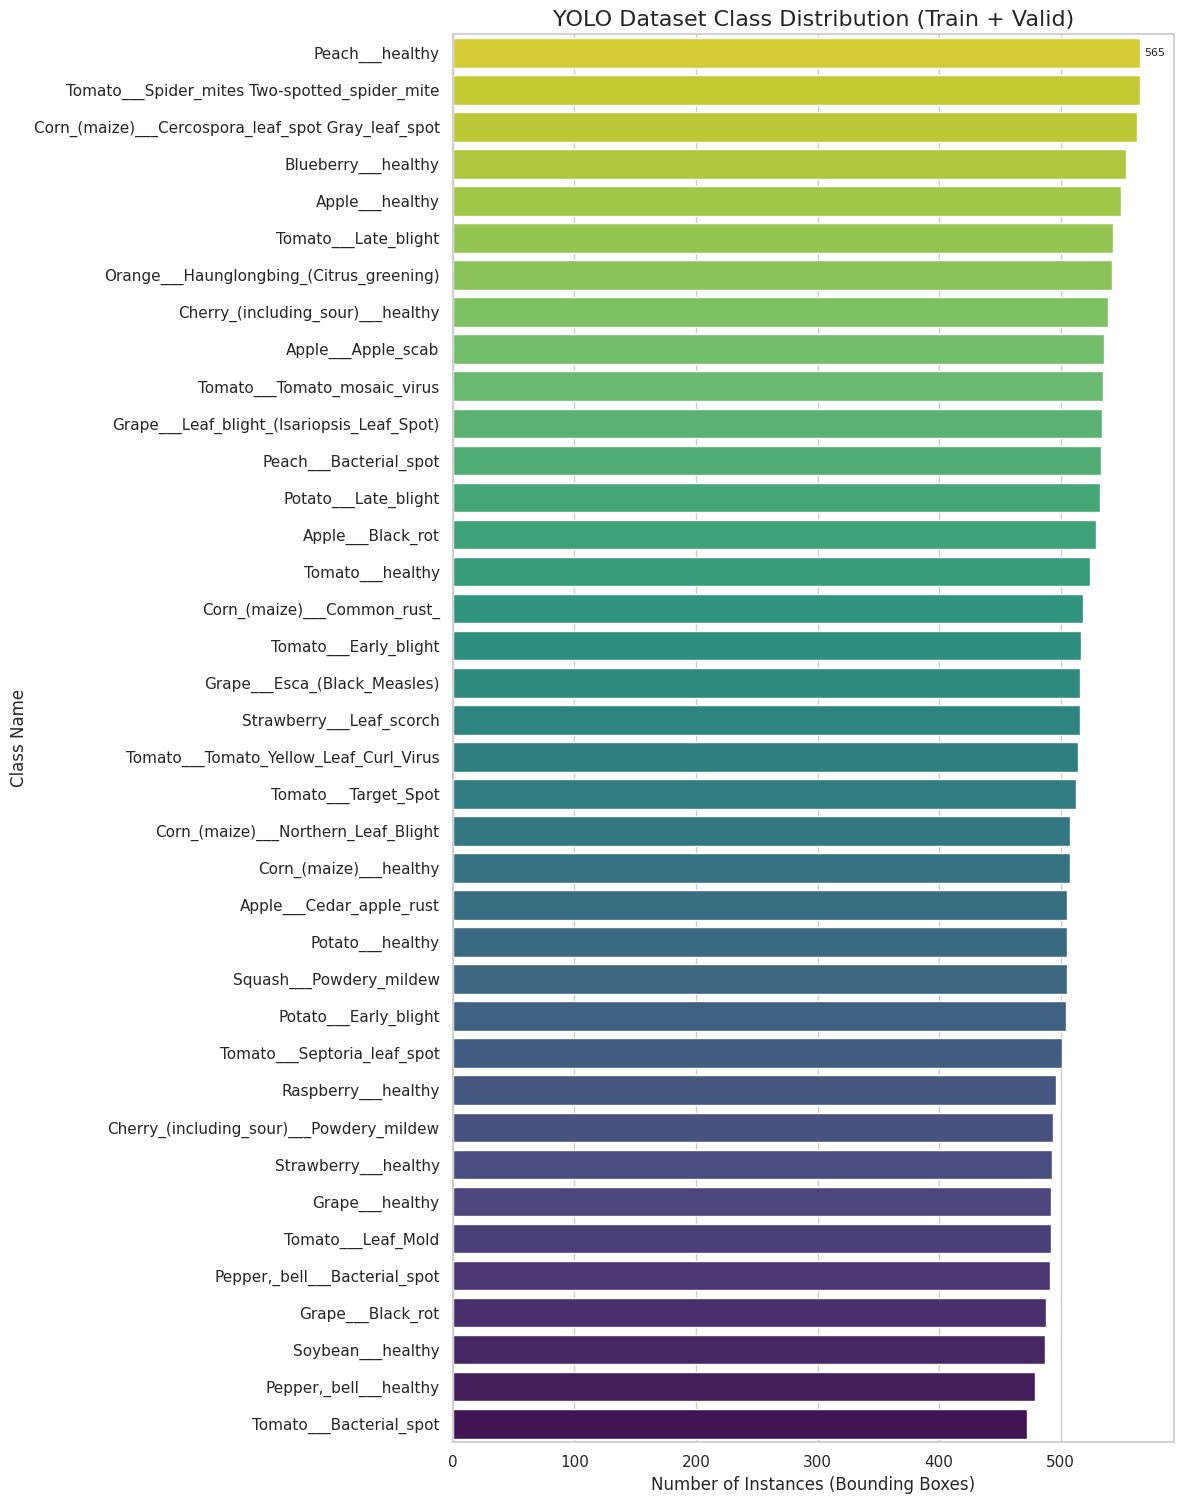


--- Class Distribution Summary (All Classes) ---
Peach___healthy                              : 565 instances
Tomato___Spider_mites Two-spotted_spider_mite: 565 instances
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 563 instances
Blueberry___healthy                          : 554 instances
Apple___healthy                              : 550 instances
Tomato___Late_blight                         : 543 instances
Orange___Haunglongbing_(Citrus_greening)     : 542 instances
Cherry_(including_sour)___healthy            : 539 instances
Apple___Apple_scab                           : 536 instances
Tomato___Tomato_mosaic_virus                 : 535 instances
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   : 534 instances
Peach___Bacterial_spot                       : 533 instances
Potato___Late_blight                         : 532 instances
Apple___Black_rot                            : 529 instances
Tomato___healthy                             : 524 instances
Corn_(maize)___Common_rust_   

In [ ]:
# --- Configuration ---
# IMPORTANT: Update this path to point to your data.yaml file
YAML_FILE_PATH = '/content/synthetic_plant_dataset/data.yaml'
# ---

def visualize_yolo_distribution(yaml_path):
    """
    Parses a YOLO dataset's data.yaml, counts class instances in train/valid
    label files, and generates a bar plot of the distribution.
    """

    # 1. Load data.yaml
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)
    except FileNotFoundError:
        print(f"Error: data.yaml not found at {yaml_path}")
        print("Please update the 'YAML_FILE_PATH' variable in the script.")
        return
    except Exception as e:
        print(f"Error loading YAML: {e}")
        return

    # Get class names and dataset root path
    class_names = data.get('names', [])
    if not class_names:
        print("Error: 'names' (class list) not found in data.yaml")
        return

    dataset_root = data.get('path', os.path.dirname(yaml_path))
    if not dataset_root:
        print("Error: 'path' (dataset root) not found in data.yaml. Assuming YAML directory.")
        dataset_root = os.path.dirname(yaml_path)

    print(f"Dataset root set to: {dataset_root}")
    print(f"Found {len(class_names)} classes.")

    # 2. Find label directories (train and valid)
    # Assumes standard YOLO structure: {dataset_root}/labels/{split}
    label_dirs = [
        os.path.join(dataset_root, 'labels', 'train'),
        os.path.join(dataset_root, 'labels', 'valid')
    ]

    # 3. Find all label files
    class_counts = Counter()
    label_files = []

    for l_dir in label_dirs:
        if not os.path.isdir(l_dir):
            print(f"Warning: Label directory not found, skipping: {l_dir}")
            continue

        # Find all .txt files in the directory
        files = glob.glob(os.path.join(l_dir, '*.txt'))
        label_files.extend(files)
        print(f"Found {len(files)} label files in {l_dir}")

    if not label_files:
        print(f"Error: No label files (*.txt) found in any directory: {label_dirs}")
        return

    print(f"\nParsing {len(label_files)} total label files...")

    # 4. Parse files and count classes
    for file_path in label_files:
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:  # Ensure line is not empty
                        class_index = int(parts[0])

                        # Validate class index
                        if 0 <= class_index < len(class_names):
                            class_counts[class_index] += 1
                        else:
                            print(f"Warning: Skipping unknown class index {class_index} in {file_path}")
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # 5. Map counts to class names
    distribution = {}
    # Initialize all classes with 0 counts to include them in the plot
    for i, name in enumerate(class_names):
        distribution[name] = class_counts.get(i, 0)

    if not class_counts:
        print("No class instances were found in any label files.")
        return

    # 6. Sort for plotting (by count, descending)
    sorted_items = sorted(distribution.items(), key=lambda item: item[1], reverse=True)
    plot_names = [item[0] for item in sorted_items]
    plot_counts = [item[1] for item in sorted_items]

    # 7. Visualize
    print("Generating plot...")

    # Dynamically adjust height based on number of classes
    num_classes = len(plot_names)
    # Allocate approx 0.4 inches per class, with a minimum of 12 inches
    fig_height = max(12, num_classes * 0.4)
    plt.figure(figsize=(12, fig_height))

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(
        x=plot_counts,
        y=plot_names,
        palette="viridis_r"  # Use a color palette
    )

    plt.title('YOLO Dataset Class Distribution (Train + Valid)', fontsize=16)
    plt.xlabel('Number of Instances (Bounding Boxes)', fontsize=12)
    plt.ylabel('Class Name', fontsize=12)

    # Add count labels to the end of each bar
    # Adjust font size based on number of classes to prevent overlap
    label_fontsize = max(6, 12 - (num_classes // 8))
    ax.bar_label(ax.containers[0], padding=3, fontsize=label_fontsize)

    plt.tight_layout()

    # Save the plot
    plot_filename = 'class_distribution.png'
    plt.savefig(plot_filename)
    print(f"\nPlot saved successfully as {plot_filename}")

    # Show the plot
    plt.show()

    # 8. Print text summary
    print("\n--- Class Distribution Summary (All Classes) ---")
    for name, count in sorted_items:
        print(f"{name:<45}: {count} instances")

# --- Run the script ---
if __name__ == "__main__":
    visualize_yolo_distribution(YAML_FILE_PATH)

In [ ]:
!zip -r /content/synthetic_plant_dataset.zip /content/synthetic_plant_dataset

In [ ]:
# Download dataset

from google.colab import files
files.download('synthetic_plant_dataset.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>